<center><h1>Music recommendation using graphs</h1>
<h2>MLNS PROJECT</h2>
<h3>Coded by Chloé Daems, Amir Mahmoudi and Anne-Claire Laisney</h3>
</center>

This is the main notebook to create a benchmark of graph based music recommendation systems inspired by the *Katarya, R., Verma, O.P. Efficient music recommender system using context graph and particle swarm. Multimed Tools Appl 77, 2673–2687 (2018).* [paper](URL 'https://link.springer.com/article/10.1007/s11042-017-4447-x'), using data from the user.getRecentTracks of the [Last.fm](URL 'https://www.last.fm/api/show/user.getRecentTracks') API.

In [9]:
#Import the libraries
from os.path import exists
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.sparse import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

from IPython.display import clear_output

## Create the graph

**Get the dataset**

In [20]:
user_id_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep = '\t')

if not exists('lastfm-dataset-1K/user_id_logs_v2.tsv'):
    logs_columns = ['userid', 'timestamp', 'artist-id', 'artist-name', 'track-id', 'track-name']
    user_id_logs = pd.read_csv('lastfm-dataset-1K/userid-logs.tsv', sep = '\t', header = None, names =  logs_columns )
    user_id_logs = user_id_logs.dropna(subset=['track-name','artist-name', 'artist-id'])
else : 
    user_id_logs = pd.read_csv('lastfm-dataset-1K/user_id_logs_v2.tsv',index_col=0)
    user_id_logs = user_id_logs.dropna(subset=['track-name','artist-name', 'artist-id'])
    
#user_id_logs['timestamp'] = pd.to_datetime(user_id_logs['timestamp'], format='%Y-%m-%dT%H:%M:%SZ')
user_id_logs['timestamp'] = pd.to_datetime(user_id_logs['timestamp'], format='%Y-%m-%d')# %H:%M:%S')


C:\Users\Windows\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [21]:
user_id_profile.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [22]:
user_id_logs.head()

,userid,timestamp,artist-id,artist-name,track-id,track-name
0,user_000001,2009-05-04 23:08:57+00:00,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,7369ec4f-b377-5683-86bd-f02897317103,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04 13:54:10+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,8a0799b1-2f64-5e7b-9436-2228c9d65637,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04 13:52:04+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,44da66dc-6a34-54de-a4d9-686bc38ede0f,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04 13:42:52+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,e625acbe-1360-528d-8afe-4ad88424e0c0,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04 13:42:11+00:00,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,fa332ed7-b701-5669-9e8e-0961658cdb43,Mc1 (Live_2009_4_15)


**There are too many track-ids missing, we are going to recreate them using the uuid library**

In [67]:
# Really long : 40 min
import tqdm
import uuid
if not exists('lastfm-dataset-1K/user_id_logs_v2.tsv'):
    for idx, row in tqdm.tqdm(user_id_logs.iterrows()):
        row['track-id'] = uuid.uuid5(uuid.NAMESPACE_DNS, row['artist-name'] + "," + row['track-name'])
        row['artist-id'] = uuid.uuid5(uuid.NAMESPACE_DNS, str(row['artist-name']))
    #We save the file
    user_id_logs.to_csv('lastfm-dataset-1K/user_id_logs_v2.tsv')

else:
    user_id_logs=pd.read_csv('lastfm-dataset-1K/user_id_logs_v2.tsv')

**We create a train and test set**

In the test set, we would have only the last month of listening for each users.

In [ ]:
test_user_id_logs = user_id_logs[user_id_logs['timestamp'] > datetime.datetime(2009, 4, 4)]
train_user_id_logs = user_id_logs[user_id_logs['timestamp'] < datetime.datetime(2009, 4, 4)]

In [ ]:
print(f'train shape : ({train_user_id_logs.shape} and test shape : ({test_user_id_logs.shape})')

train shape : ((17815729, 6) and test shape : ((682269, 6))


In [ ]:
val_user_id_logs = train_user_id_logs[train_user_id_logs['timestamp'] > datetime.datetime(2009, 3, 4)]
train_user_id_logs = train_user_id_logs[train_user_id_logs['timestamp'] < datetime.datetime(2009, 3, 4)]

In [ ]:
print(f'train shape : ({train_user_id_logs.shape} and val shape : ({val_user_id_logs.shape})')

train shape : ((17217876, 6) and val shape : ((597852, 6))


**Let's only take the n most listened songs of each users**

In [ ]:
def get_only_top(df_logs,df_profile, n_top):
    new_df = pd.DataFrame(columns = ['track-name','artist-name'], dtype= np.str)
    for user_id in df_profile.values:
        test = df_logs[df_logs['userid']== user_id]
        try:
            test['count'] = test.groupby(['track-id'])[['track-id']].transform(lambda x: x.count())['track-id']
            test = test.sort_values(by = 'count', ascending = False)
            test = test.drop('timestamp', axis = 1)
            test = test.drop_duplicates()
            new_df = pd.concat([new_df, test[:n_top]], ignore_index=True)
        except:
            pass
        clear_output(wait = True)
        print("Just finished for",user_id)
    return new_df

In [ ]:
if not exists('./saved_data/train_user_top_logs.tsv'):
    train_user_top_logs = get_only_top(train_user_id_logs,user_id_profile['#id'], n_top = 50)
    train_user_top_logs = train_user_top_logs.nlargest(10000,'count')
    train_user_top_logs.to_csv('./saved_data/train_user_top_logs.tsv')

else : 
    train_user_top_logs = pd.read_csv('./saved_data/train_user_top_logs.tsv', index_col=0)

train_user_top_logs.head()

,track-name,artist-name,userid,artist-id,track-id,count
0,Music,Cornelius,user_000001,df765d93-621c-437f-99fe-fda9e135f89a,52bef5e2-17b6-5742-b846-09a6b750e857,70.0
1,Gum,Cornelius,user_000001,df765d93-621c-437f-99fe-fda9e135f89a,bb9a7981-016d-596e-b17f-ba07a346d2d4,63.0
2,Mario Basanov & Vidis ‘Test’,Gilles Peterson,user_000001,4c4e3121-4d12-4f7a-a77c-5becd849fb3c,7434fb0f-1245-5a58-b343-cca4d0e2c107,50.0
3,Child Song,The Cinematic Orchestra,user_000001,7c158ea8-c0aa-410e-bdc1-20bba9759577,4562ff4f-b619-5557-8600-87f6d0d9f348,44.0
4,To Build A Home,The Cinematic Orchestra,user_000001,7c158ea8-c0aa-410e-bdc1-20bba9759577,dcf825de-85a9-5b53-9d2b-a9d574b57470,41.0


**Transform the dataset into a bipartite graph**

In [ ]:
if not exists('./saved_data/track_df.tsv'):
    track_df = train_user_top_logs.copy()
    track_df.drop(['count', 'userid'], axis = 1, inplace=True)
    track_df.drop_duplicates('track-id', inplace=True)
    track_df.reset_index(drop=True, inplace=True)
    track_df.to_csv('./saved_data/track_df.tsv')
else : 
    track_df = pd.read_csv('./saved_data/track_df.tsv', index_col=0)

track_df.head()

,track-name,artist-name,artist-id,track-id
0,Music,Cornelius,df765d93-621c-437f-99fe-fda9e135f89a,52bef5e2-17b6-5742-b846-09a6b750e857
1,Gum,Cornelius,df765d93-621c-437f-99fe-fda9e135f89a,bb9a7981-016d-596e-b17f-ba07a346d2d4
2,Mario Basanov & Vidis ‘Test’,Gilles Peterson,4c4e3121-4d12-4f7a-a77c-5becd849fb3c,7434fb0f-1245-5a58-b343-cca4d0e2c107
3,Child Song,The Cinematic Orchestra,7c158ea8-c0aa-410e-bdc1-20bba9759577,4562ff4f-b619-5557-8600-87f6d0d9f348
4,To Build A Home,The Cinematic Orchestra,7c158ea8-c0aa-410e-bdc1-20bba9759577,dcf825de-85a9-5b53-9d2b-a9d574b57470


In [ ]:
from networkx.algorithms import bipartite
#We transform the train set into a bipartite graph
G= nx.Graph()
edges = np.array(train_user_top_logs[['userid', 'track-id']].values)
G.add_nodes_from(user_id_profile['#id'], bipartite=0)
G.add_nodes_from(track_df['track-id'], bipartite=1)
     
G.add_edges_from(edges)
#weighted graph
#G.add_weighted_edges_from(edges)
#save the edges
nx.write_edgelist(G, "saved_data/graph_user_tracks_train.el")

In [ ]:
#We transform the val set into a bipartite graph

#First we select only the music tracks that are in the train set
val_user_id_logs = val_user_id_logs[val_user_id_logs['track-id'].isin(track_df['track-id'])]
val_user_id_logs_top = get_only_top(val_user_id_logs,user_id_profile['#id'], n_top = -1)

Just finished for user_001000


In [ ]:
#Concatenate the train and val sets summing the count for the same track and the same user
new_val_user_id_logs_top = pd.concat([train_user_top_logs, val_user_id_logs_top], ignore_index=True)
#sum count column for same track and same user
new_val_user_id_logs_top.drop_duplicates(['userid', 'track-id'], inplace=True)
new_val_user_id_logs_top

,track-name,artist-name,userid,artist-id,track-id,count
0,Music,Cornelius,user_000001,df765d93-621c-437f-99fe-fda9e135f89a,52bef5e2-17b6-5742-b846-09a6b750e857,70.0
1,Gum,Cornelius,user_000001,df765d93-621c-437f-99fe-fda9e135f89a,bb9a7981-016d-596e-b17f-ba07a346d2d4,63.0
2,Mario Basanov & Vidis ‘Test’,Gilles Peterson,user_000001,4c4e3121-4d12-4f7a-a77c-5becd849fb3c,7434fb0f-1245-5a58-b343-cca4d0e2c107,50.0
3,Child Song,The Cinematic Orchestra,user_000001,7c158ea8-c0aa-410e-bdc1-20bba9759577,4562ff4f-b619-5557-8600-87f6d0d9f348,44.0
4,To Build A Home,The Cinematic Orchestra,user_000001,7c158ea8-c0aa-410e-bdc1-20bba9759577,dcf825de-85a9-5b53-9d2b-a9d574b57470,41.0
...,...,...,...,...,...,...
125862,How To Disappear Completely,Radiohead,user_001000,a74b1b7f-71a5-4011-9441-d0b5e4122711,ccad68b7-c5ad-4f29-b169-2531fbf53f63,1.0
125863,Everything In Its Right Place,Radiohead,user_001000,a74b1b7f-71a5-4011-9441-d0b5e4122711,60bd9d53-01ff-4562-8058-eb44b3940317,1.0
125864,Under The Blacklight,Rilo Kiley,user_001000,eaf6a7ca-105d-4a94-ba02-8c3e4040319a,b912987f-8a21-4c7b-8412-f70ccd6dcd4d,1.0
125865,Dreamworld,Rilo Kiley,user_001000,eaf6a7ca-105d-4a94-ba02-8c3e4040319a,d1561c20-50c2-4a48-9f5d-a92572347ddc,1.0


In [ ]:
#Then we create the graph

G_val = nx.Graph()
edges = np.array(new_val_user_id_logs_top[['userid', 'track-id']].values)
G.add_nodes_from(user_id_profile['#id'], bipartite=0)
G.add_nodes_from(track_df['track-id'], bipartite=1)
     
G.add_edges_from(edges)
#weighted graph
#G.add_weighted_edges_from(edges)
#save the edges
nx.write_edgelist(G, "saved_data/graph_user_tracks_val.el")

In [ ]:
"""pos = nx.spring_layout(G, k=0.3, iterations = 45)
nx.draw(G,node_color=color_list, with_labels=False, pos = pos, node_size=50)
plt.show()"""

'pos = nx.spring_layout(G, k=0.3, iterations = 45)\nnx.draw(G,node_color=color_list, with_labels=False, pos = pos, node_size=50)\nplt.show()'

## Create the methods
Pearson coefficient, Bellman ford algorithm ...

**Get the graph**

In [35]:
train_G = nx.read_edgelist("saved_data/graph_user_tracks_train.el")
val_G = nx.read_edgelist("saved_data/graph_user_tracks_val.el")

### We try the methods from TP2

**Unsupervised link prediction**

ALL THE METHODS ARE TO BE PUT IN A UTIL.PY FILE

In [79]:
def preferential_attachement(graph, edges=G.edges()):
    PA = {}
    
    for edge in edges:
        PA[edge] = graph.degree(edge[0]) * graph.degree(edge[1])
        
    return PA
    
pa = preferential_attachement(G)

In [80]:
def Jaccard(graph, edges=G.edges()):
    Jaccard = {}
    # Compute Jaccard metric for each non_edge of the graph
    
    for edge in edges: 
        inter_size = len(list(nx.common_neighbors(graph, edge[0], edge[1])))
        union_size = len(set(graph[edge[0]]) | set(graph[edge[1]]))
        Jaccard[edge] = inter_size / union_size
    
    return Jaccard

In [81]:
def AdamicAdar(graph, edges=G.edges()):
    AdamicAdar = {}
    
    for edge in edges: 
        inter_list = nx.common_neighbors(graph, edge[0], edge[1])
        AdamicAdar[edge] = sum( [1/np.log(graph.degree(node)) for node in inter_list] )
    
    return AdamicAdar

In [82]:
def predict_edges(metric, k):
    
    # Shuffle randomly entries of dictionnary 
    l = list(metric.items())
    np.random.seed(10) # fix random seed to obtain same random shuffling when repeating experiment
    np.random.shuffle(l)
    metric = dict(l)

    # Retrieve top k value 
    metric = dict(sorted(metric.items(), key=lambda x:x[1], reverse=True)[:k])
    print(metric.items())

predict_edges(pa)

dict_items([(('user_000791', '830c4338-8ea6-5dad-8deb-f9f903ece418'), 100485), (('user_000791', 'd3395606-9d39-598c-b5a2-0c26a20a85bd'), 97875), (('user_000791', '4d7a8c14-dbd6-539c-8835-2a78837c274f'), 92655), (('user_000544', '830c4338-8ea6-5dad-8deb-f9f903ece418'), 91553), (('user_000791', 'fe561758-dfcc-55f4-a550-514924dcccf5'), 90045), (('user_000544', 'd3395606-9d39-598c-b5a2-0c26a20a85bd'), 89175), (('user_000791', 'e8f0781d-5c0f-5d78-bc63-9f05ba93f6fd'), 80910), (('user_000791', 'cd44f7af-fac5-5770-aea3-162c3471e0f3'), 74385), (('user_000791', '1298d63a-715a-5185-8a21-2e38a765141c'), 73080), (('user_000791', '90744886-c2db-590b-bfb6-50d409cddabf'), 73080)])


In [95]:
import tqdm
#1 hour to compute NOT TRIED -- (but the result in the state of the art is bad)
def evaluation(G_train, G_val):
    R = G_val.copy()
    R.remove_edges_from(e for e in G_train.edges if e in G_val.edges)
    gt = R.edges
    k = len(gt)
    print(k)
    print("Starting predictions")
    # --- Apply each method defined above and calculate its accuracy ---
    methods = ['Jaccard', 'AdamicAdar', 'preferential_attachement']
    
    # For each method, compute the similarity scores between all non-edges
    # Predict k node pairs with highest score 
    # Compute accuracy wrt edges actually removed 
    for method in methods: 
        res = eval(method)(G_train, nx.non_edges(G_train))
        print("predicting 4 real ")
        pred = sorted(res.items(), key = lambda x:x[1], reverse=True)[:k]
        print("I finished predicting")
        pred = [el[0] for el in pred]
        #print('pred', pred)
        #print('gt',gt)
        accuracy = len(set(pred).intersection(set(gt))) / k
        print(method, accuracy)

evaluation(train_G, val_G)

68730
Starting predictions


**Supervized link prediction**

In [61]:
from sklearn.metrics import accuracy_score,recall_score,precision_score
import collections
from tqdm import tqdm

In [49]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    '''if nx.is_connected(G) is not True:
        raise ValueError("The graph contains more than one connected component!")'''
       
    
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Store the shuffled list of current edges of the graph
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive test samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in tqdm.tqdm(edges):
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break
    
    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g, train_samples, train_labels, test_samples, test_labels

In [26]:
def feature_extractor(graph, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = []
    
    # --- Extract manually diverse features relative to each edge contained in samples --- 
    # Fill in the blanks

    # Degree Centrality measure
    deg_centrality = nx.degree_centrality(graph)
    
    # Betweeness centrality measure
    betweeness_centrality = nx.betweenness_centrality(graph)

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality measure 
        diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        aai = list(nx.adamic_adar_index(graph, [(source_node, target_node)]))[0][2]

        # Jaccard
        jacard_coeff = list(nx.jaccard_coefficient(graph, [(source_node, target_node)]))[0][2]
        
        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, 
                                        diff_bt, pref_attach, aai, jacard_coeff]) ) 
        
    return feature_vector

In [65]:
def prediction(graph, train_features, test_features, train_labels, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    # Fill in the blanks
    clf = LogisticRegression()
    clf.fit(train_features, train_labels)

    test_preds = clf.predict_proba(test_features)[:, 1]
    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    #compute accuracy
    #test_preds=clf.predict(test_features)
    for i in range(len(test_preds)):
        if test_preds[i]>0.25:
            test_preds[i]=1
        else:
            test_preds[i]=0
    print(collections.Counter(np.array(test_preds)))
    acc=accuracy_score(test_labels,test_preds)
    recall=recall_score(test_labels,test_preds)
    precision=precision_score(test_labels,test_preds)
    """
    plot
    """
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc,acc,recall,precision

In [3]:
def get_sets(graph):
    pos_sample=list(graph.edges)
    neg_sample=list(nx.non_edges(graph))
    labels = [1 for _ in pos_sample] + [0 for _ in neg_sample]
    features=pos_sample+neg_sample
    return features,labels

In [40]:
#The graph is too big to be used for training and validation
# We can remove the low degree nodes
def remove_low_degree_nodes(train_graph, val_graph):
    t_graph, v_graph = train_graph.copy(), val_graph.copy()
    to_be_removed = [x for  x in train_graph.nodes() if train_graph.degree(x) <= 3]
    print(len(to_be_removed))
    t_graph.remove_nodes_from(to_be_removed)
    v_graph.remove_nodes_from(to_be_removed)
    return t_graph, v_graph

In [41]:
train_G,val_G = remove_low_degree_nodes(train_G,val_G)

35624


In [49]:
# --- Construct the training and testing sets ---
#residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.6)
train_samples, train_labels=get_sets(train_G)
test_samples, test_labels =get_sets(val_G)
print('Feature extraction ...')
# --- Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(train_G, train_samples)
test_features = feature_extractor(val_G, test_samples)

Feature extraction ...


100%|██████████| 2104326/2104326 [03:12<00:00, 10938.83it/s]

Starting predictions ...


Starting predictions ...
Counter({0.0: 1877211, 1.0: 227115})


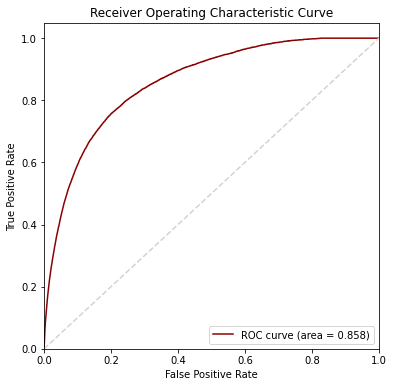

(0.8581377744818911,
 0.8938719571017039,
 0.6008951883625513,
 0.04965325936199723)

In [66]:
print('Starting predictions ...')
# --- Link prediction ---
prediction(val_G, train_features, test_features, train_labels, test_labels)